# 스팀데이터 2차 전처리 후 분석


(2017년 08월 12일 작성)

앞에서는 모은 데이터들을 좀더 효율적으로, 빠르게 분석하기 위한 전체적인 전처리 과정을 거쳤지만,
좀 더 세부적으로 데이터를 구분하기 위하여 두번째 전처리를 거친 후 본격적으로 분석을 시작한다.


-----------------------------
아래는 파이썬코드부분 입니다.

-----------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import datetime
from collections import defaultdict
from dateutil.parser import parse as parse_date
import sklearn.preprocessing as skp

In [707]:
#import statsmodels.api as sm
import scipy as sp

In [714]:
df=pd.read_csv('./Steam_data_Fix_Inform_2.1ver.csv')

여기서 게임장르는 스팀에서는 'Tag'로 이름을 따로 붙인다. 게임장르를 처음 데이터로 필자가 모을 때는 퍼즐장르를 전제로 깔고 액션,어드벤처,호러 구분지어서 값을 넣어줬으나, 장르라는 것을 명확하게 자를 수가 없어서,결국 수집된 데이터들의 공통적 Tag인 Puzzle 을 집어넣었다.

In [715]:
df['장르']='Puzzle'
del df['Unnamed: 0']
del df['VIEW']

column_rename=['gameName','InvestigateDate','SteamReview','NonSteamReview','ReleaseDateinSteam','Rating','Price','EngineorLanguage',"Tag",
              'VideoRegisterDate','CompanyName','FoundingDateofCompany','ThisYear','Nationaility','Ownersdate','TotalSteamReview',
               'Publicity PeriodofYoutube','CompanyDurationDate','totalSales'
              ]
df.columns=column_rename

#df['EngineorLanguage']=df['EngineorLanguage'].map({'질문중-youtube':'StillQuestioning'})
df.loc[(df.EngineorLanguage =='질문중-youtube') | (df.EngineorLanguage=='질문중-steam')|
       (df.EngineorLanguage =='질문중 -steam') | (df.EngineorLanguage=='질문중 -Youtube')|
       (df.EngineorLanguage =='질문중 -Steam') | (df.EngineorLanguage=='데탑으로 다시보기')|
       (df.EngineorLanguage =='질문해야함-누가 질문해놨음') | (df.EngineorLanguage=='질문해야함'),

       'EngineorLanguage']='StillQuestioning'

엔진을 모르는(질문을 했으나 아직도 답변이 오지않은) 게임들의 개수를 확인한다

In [716]:
len(df.loc[(df.EngineorLanguage =='StillQuestioning'),'EngineorLanguage']) 

189

게임을 출시할 당시에 신생 기업(혹은 개발자)인지 아닌지 확인(신생기업은 1년이하로 잡는다)

게임을 출시한 연도와 회사설립 연도를 뺀다.

In [717]:
df['ReleaseDateinSteam']=pd.to_datetime(df['ReleaseDateinSteam'])
df['InvestigateDate']=pd.to_datetime(df['InvestigateDate'])
df['ReleaseDate_Year']=df['ReleaseDateinSteam'].dt.year #datetime 의 2017-01-01 형식에서 연도(2017)만빼온다.
df['CheckStartUporNewbyDeveloper']=df['ReleaseDate_Year']-df['FoundingDateofCompany']
df['CheckStartUporNewbyDeveloper']=pd.to_numeric(df['CheckStartUporNewbyDeveloper'])

In [718]:
df['CountallCompanybyCountry']=1

In [719]:
#신생기업, 신생기업이아닌기업들 구분
df.loc[(df.CheckStartUporNewbyDeveloper<=3),'CheckStartUporNewbyDeveloper'] = 1

df.loc[(df.CheckStartUporNewbyDeveloper>3) ,'CheckStartUporNewbyDeveloper']=0



3년이하 신생기업들은 1,
3년 초과 인 기업들은 0으로 표시한다.
후에 그래프를 그려야하는데, 매출액과 다운로드수의 각 value 값들이 너무나 천차만별이라서, 산포도를 그릴경우 및 각 Feature들의 관계를 나타낼 때 매우 부정확한 수를 나타낼 수 있으므로, 이를 개선하기위해 log를 씌워준다. np.log의 밑은 e (네이피어 수) 이다.

In [720]:
df['log_totalSales']=np.log(df.loc[df.loc[:,'totalSales']!=0,'totalSales'])
df['log_totalSales'].fillna(0,inplace=True)
df['log_Ownersdata']=np.log(df['Ownersdate'])


값의 공백 여부로 인해, 공통된 요소가 아니게 되버린 값을 재정의해준다.

In [721]:
df.loc[df.loc[:,'EngineorLanguage']=='RPG Maker VX ','EngineorLanguage']='RPG Maker VX'

최종 전처리를 다 끝마친 후, 불필요한 칼럼들은 제거한뒤 본격적인 분석을 시작할 준비를 한다.

In [722]:
df2=df.drop(['Tag','ThisYear','SteamReview','NonSteamReview'],axis=1)

회사들의 초창기 설립날짜들을 연도별 그래프로 나열해보았다.

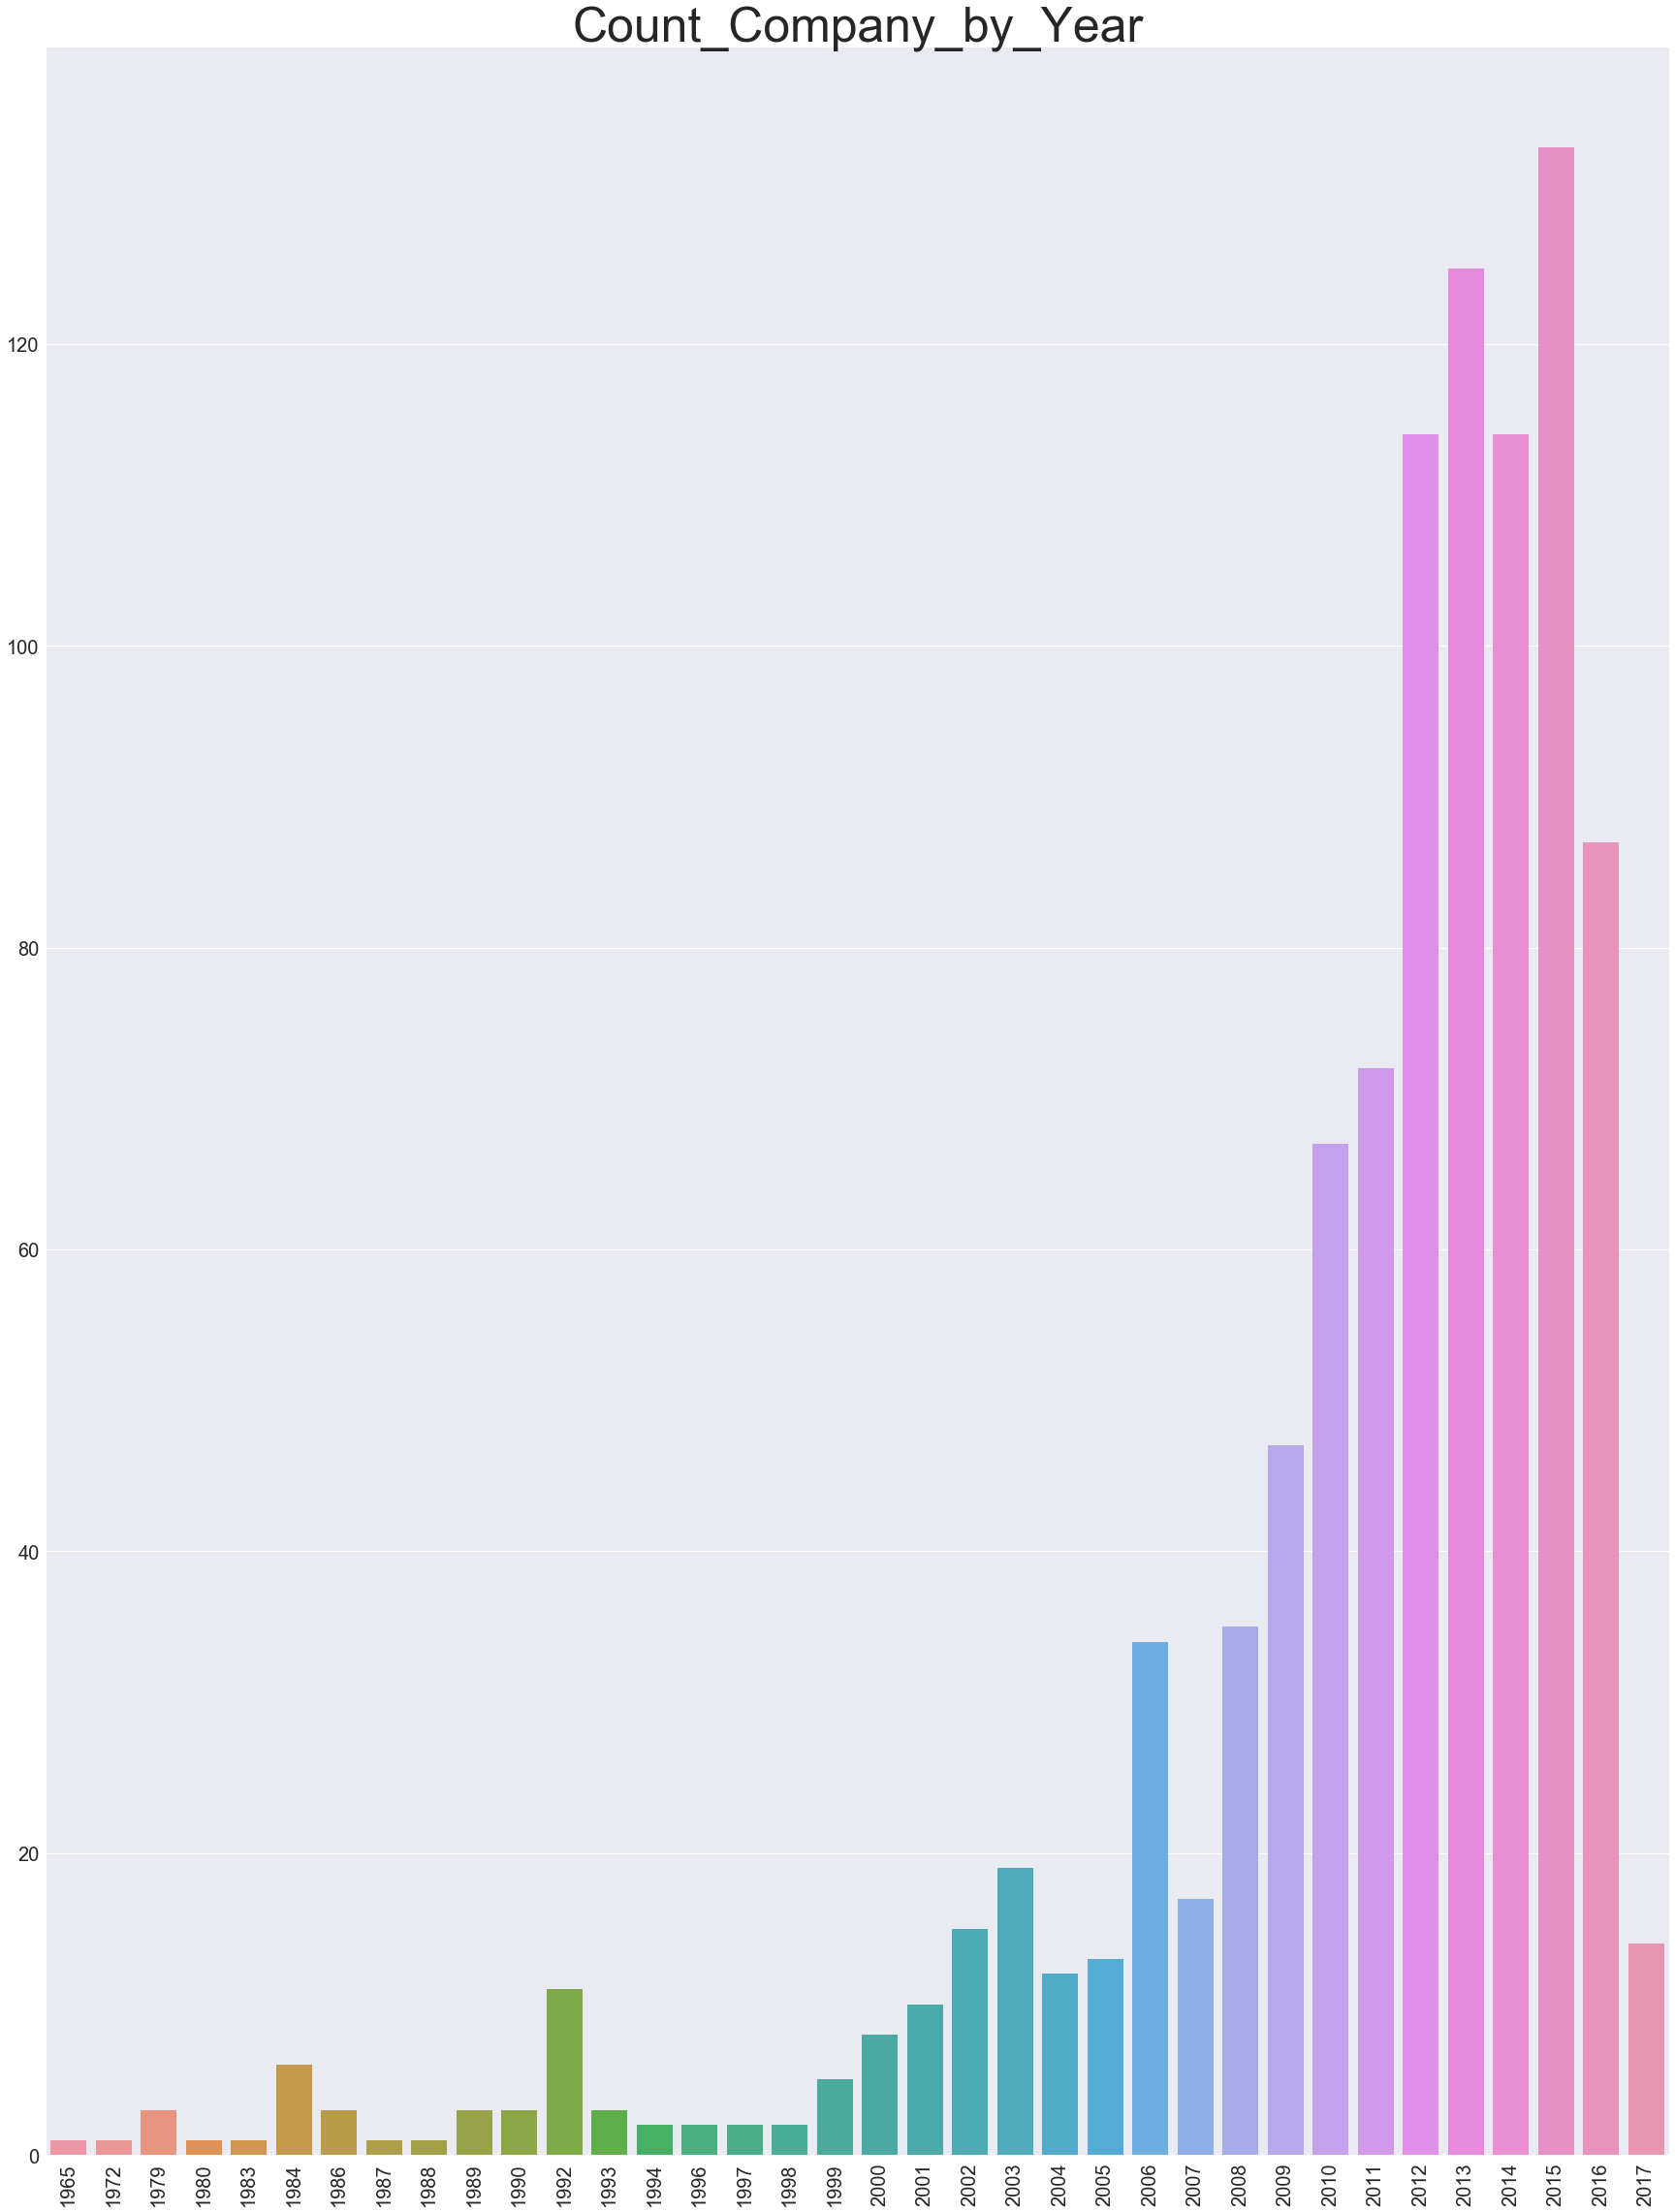

In [723]:
plt.figure(figsize=(30,40))
#df2.FoundingDateofCompany.value_counts().sort_index().valuex
ax=sns.barplot(df2.FoundingDateofCompany.value_counts().sort_index().index,df2.FoundingDateofCompany.value_counts().sort_index().values)
ax.set_xticklabels(df2.FoundingDateofCompany.value_counts().sort_index().index,rotation=90,fontsize=20)
ax.set_title('Count_Company_by_Year',size=50)
plt.rc('ytick',labelsize=20)
plt.show()

스팀에서 퍼즐태그(장르)를 달고있는 게임들의 제작 엔진 혹은 프로그래밍언어들의 사용빈도를 그래프로 나타내보았다.

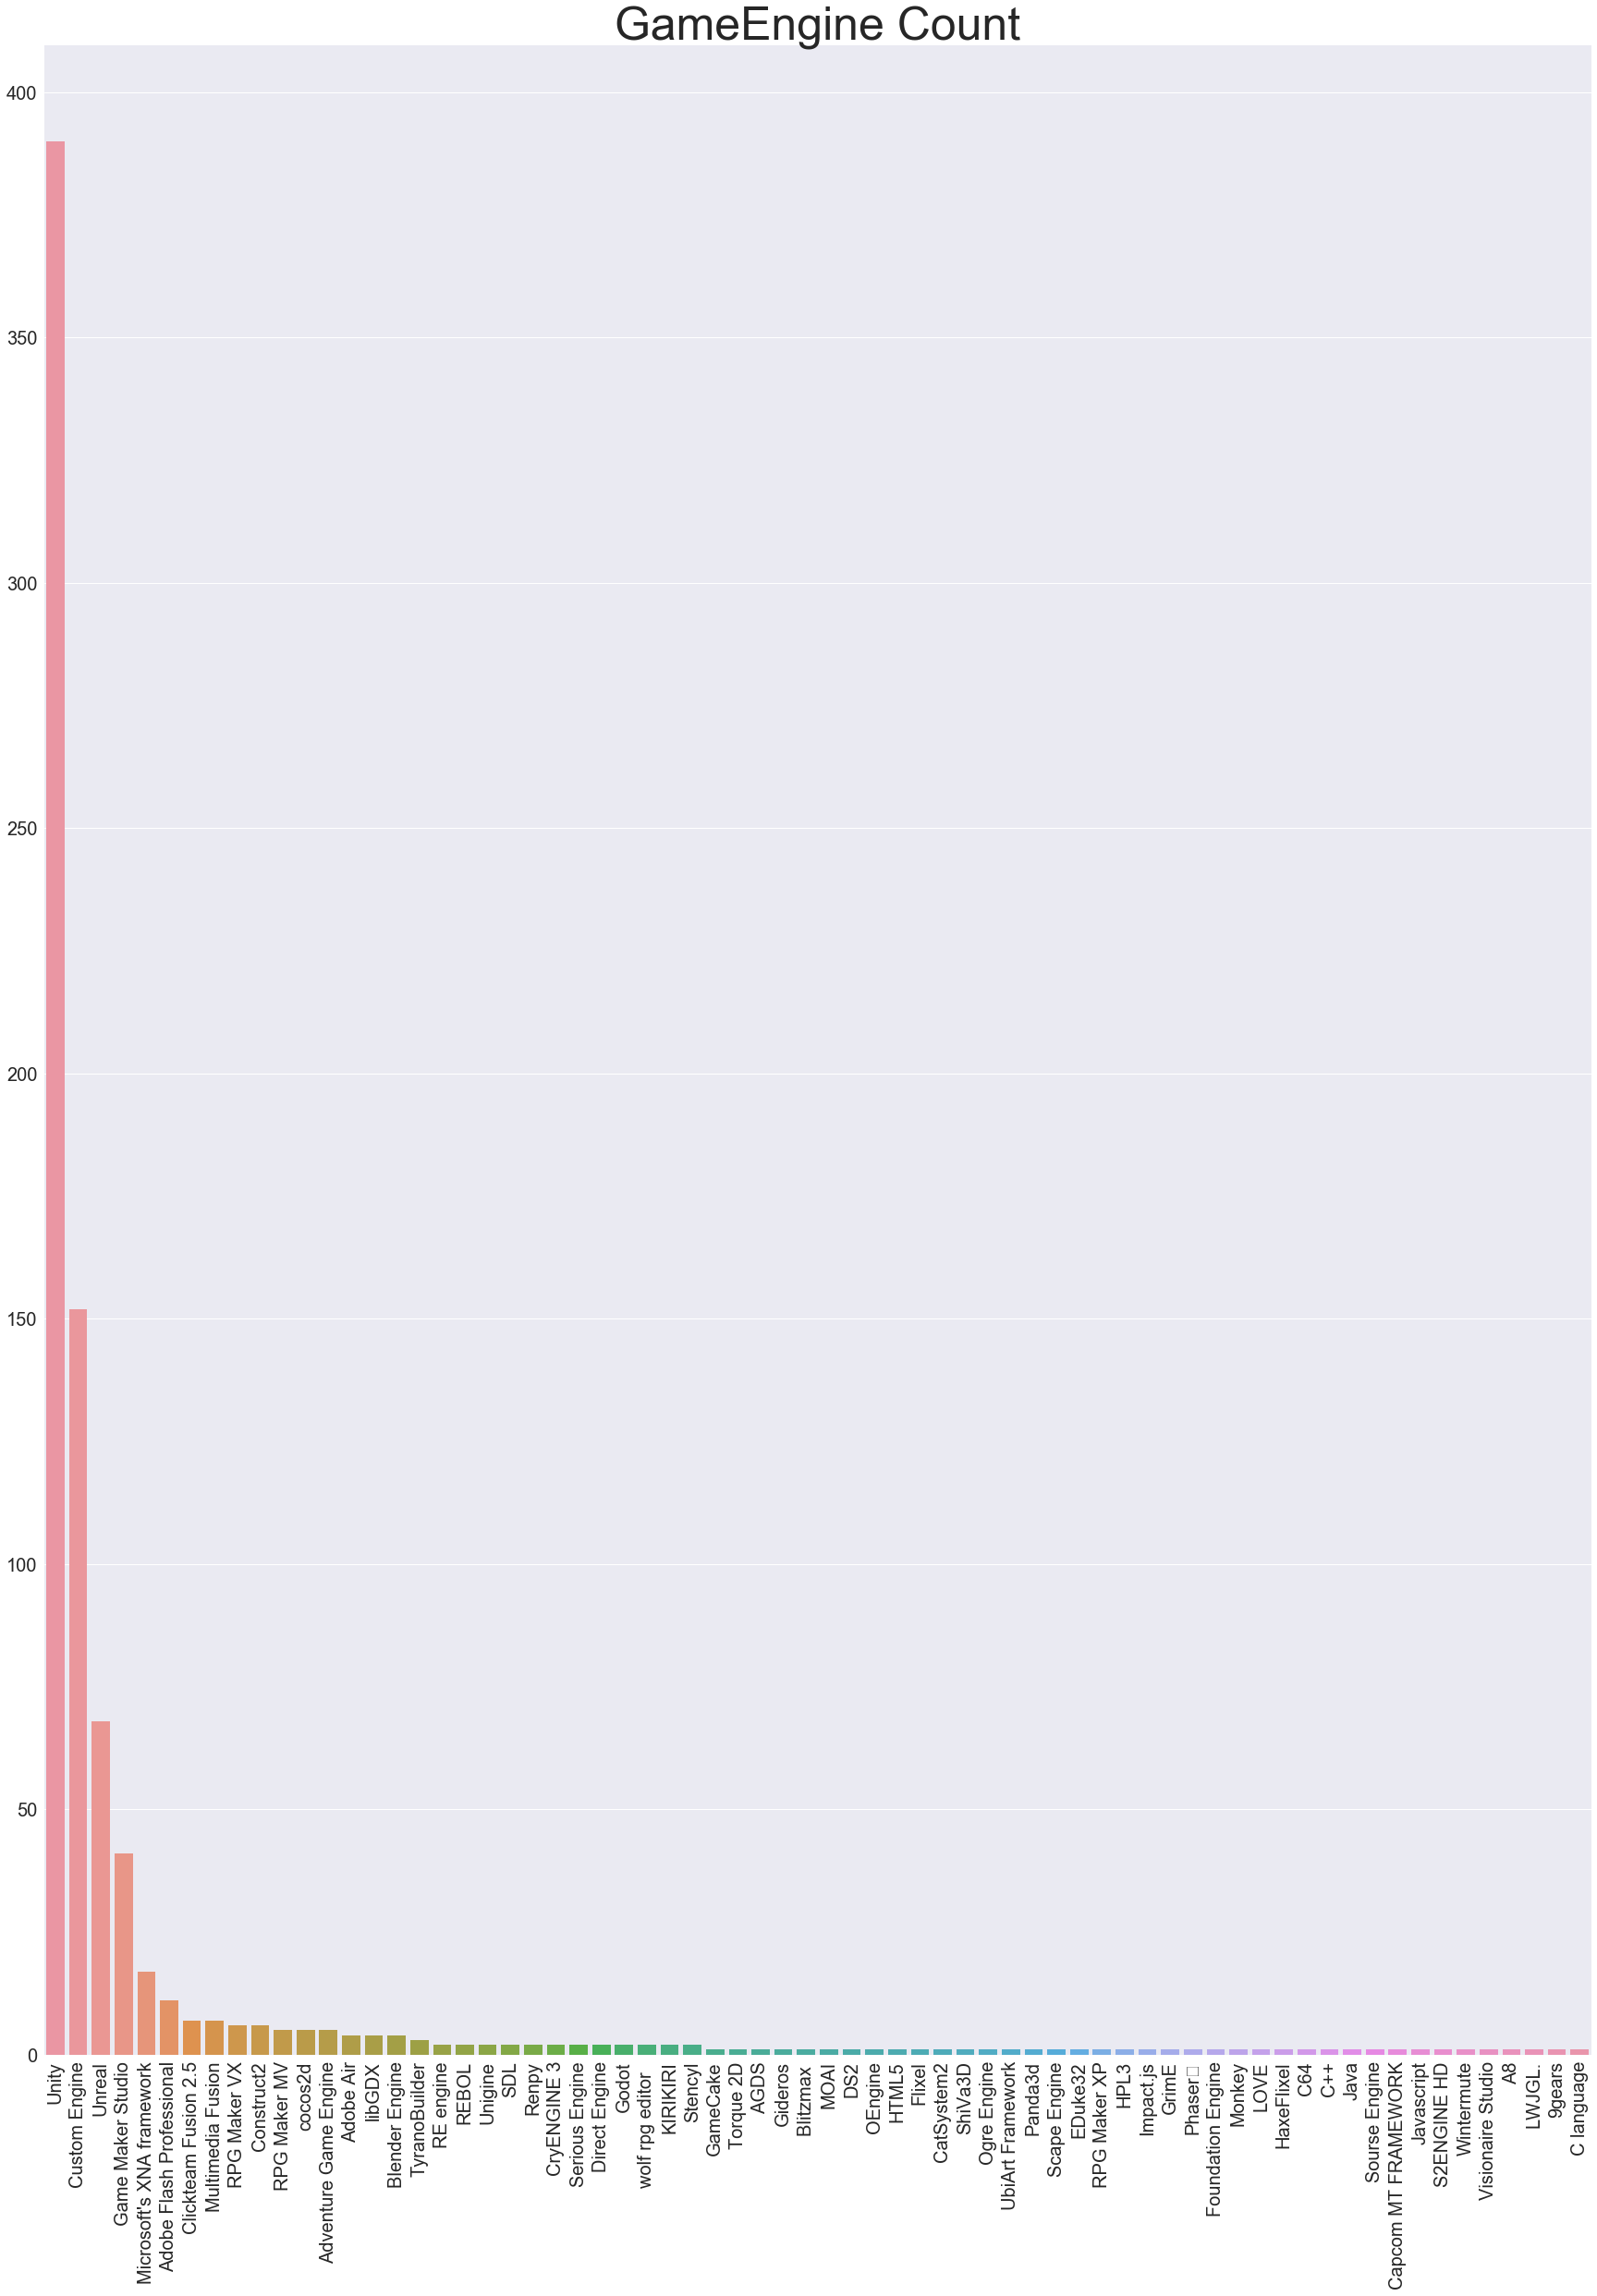

In [724]:
EngineCount=df2['EngineorLanguage'].value_counts().drop('StillQuestioning')
plt.figure(figsize=(30,40))
ax=sns.barplot(EngineCount.index,EngineCount.values)
ax.set_xticklabels(EngineCount.index,rotation=90,fontsize=20)
ax.set_title('GameEngine Count',size=50)
plt.rc('ytick',labelsize=20)
plt.show()

987개의 엔진 중 확인되지 않은 엔진들을 제외하면 796개의 엔진 데이터가 나왔다.
이중 회사 내부엔진,자체제작 엔진들을 제외하고 순위를 매기면 아래와 같다.
- Unity                        390개
- Unreal                        68개
- Game Maker Studio             41개
- Microsoft's XNA framework     17개
- Adobe Flash Professional      11개
- Multimedia Fusion              7개
- Clickteam Fusion 2.5           7개
- RPG Maker VX                   6개
- Construct2                     6개
- RPG Maker MV                   5개
- cocos2d                        5개

이 외 엔진 및 프로그래밍언어의 빈도수는 아래에 명시하였다.

In [725]:
EngineCount.value_counts

<bound method IndexOpsMixin.value_counts of Unity                        390
Custom Engine                152
Unreal                        68
Game Maker Studio             41
Microsoft's XNA framework     17
Adobe Flash Professional      11
Clickteam Fusion 2.5           7
Multimedia Fusion              7
RPG Maker VX                   6
Construct2                     6
RPG Maker MV                   5
cocos2d                        5
Adventure Game Engine          5
Adobe Air                      4
libGDX                         4
Blender Engine                 4
TyranoBuilder                  3
RE engine                      2
REBOL                          2
Unigine                        2
SDL                            2
Renpy                          2
CryENGINE 3                    2
Serious Engine                 2
Direct Engine                  2
Godot                          2
wolf rpg editor                2
KIRIKIRI                       2
Stencyl                        2

------------------------------------------------

In [726]:
def countUnity(df):
    return df[df.loc[:,'EngineorLanguage']=='Unity'].count()
def countUnreal(df):
    return df[df.loc[:,'EngineorLanguage']=='Unreal'].count()
def countGameMakerStudio(df):
    return df[df.loc[:,'EngineorLanguage']=='Game Maker Studio'].count()



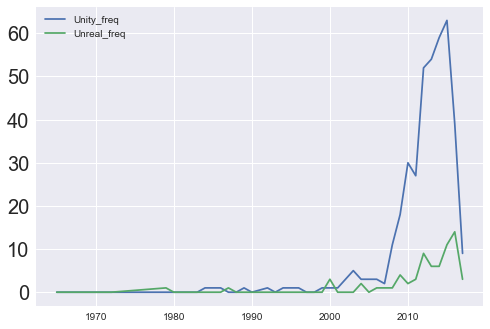

In [727]:
count_df_Unity=df.groupby('FoundingDateofCompany').agg(countUnity)
count_df_Unreal=df.groupby('FoundingDateofCompany').agg(countUnreal)
plt.plot(count_df_Unity.index, count_df_Unity.EngineorLanguage.values,label="Unity_freq")
plt.plot(count_df_Unreal.index, count_df_Unreal.EngineorLanguage.values,label='Unreal_freq')
plt.legend(loc=2)
plt.show()

회사 초기설립년도 기준으로 언리얼과 유니티의 사용빈도 추이를 보여준다. 이는 다른 엔진통계들과 비교해볼때, 해마다 두 엔진은 꾸준히 지속적으로 사용빈도가 높아진다는 것과 동일하다

앞서 나타냈던 'CountCompany_by_year'그래프 를 보면 알 수 있듯이, 게임을 만드는 startup회사 및 개인 개발자들의 수가 2000년 초반부터 증가하고 있음을 알 수 있으며, 'EngineCount' 그래프에서 보면 엔진에서 라이브러리로 제공되는 알고리즘, 점점 사람들이 low-level부터 개발단계를 거치지 않고도, 자신의 아이디어만 있다면 손쉽게 게임 제작을 도와주는 엔진들의 사용 빈도수가 높아짐을 보여주어, 게임산업은 점점 진입장벽이 낮아진다고 생각해 볼 수 있다. 특히 이러한 쪽으로 강세를 보이고 있는,Unity엔진이 정말 압도적으로 많고(390개), 그 다음으로 Unreal엔진(68개), 2D에서 많이 쓰이는 Gamemakerstudio 엔진 (40)개 순으로 나열된다.(상용화되지않은 커스텀 엔진은 순위에서 제외)  
물론 필자가 모은 데이터는 1000개뿐이기도 하고, 이중에서 owners_data가 나와있지 않은 게임을 제외하면(DLC추가판 및 스팀 스파이에 등록 되어 있지 않은 게임) 987개의 데이터밖에 되지 않는다. 하지만, 점차적으로 게임분야에서의 스타트업 회사 및 인디 개발자들이 매년 늘어나는 것은, ICT기술들, 빅데이터와 가상현실 분야들의 관심이 글로벌적으로 높아짐에 따라 사회적으로 부합하는, 당연한 추세라고 생각된다. 

이제 기존에 생각했던 주제인 게임다운로드수는 회사존속기간과 연관이 있는가에 대한 도표를 아래에 나타낼 것이다.

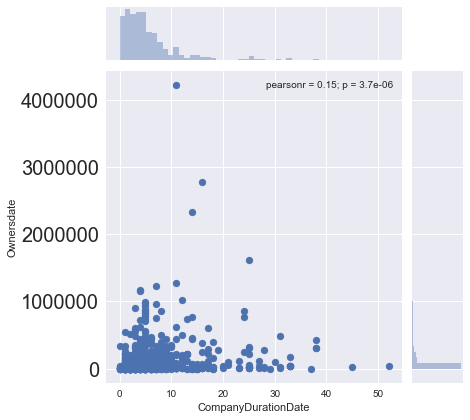

In [728]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['CompanyDurationDate'], y=df['Ownersdate'])
plt.show()

우선 log 를 씌우지 않았을 때를 도표로 그려보았는데, 
pearsonr 은 상관관계를 의미하며,
p 는 유의성검정 , 통계학에서 흔히들말하는 p_value를 의미한다.

상관관계는 0.15 이고,
유의성은 3.7e-06이 나왔다.

상관관계는 없다고 결론이 지어진다.
하지만 위에 표를 보면 y축 값들의 숫자간 간격이 너무 크기 때문에 log를 씌운 도표를 아래에 다시 그려보았다.

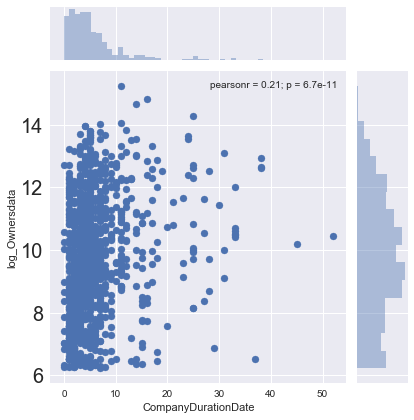

In [729]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['CompanyDurationDate'], y=df['log_Ownersdata'])
plt.show()

위에 도표는 log를 씌웠을때 도표이며, 상관관계는 0.21 이 나왔다.
기존에 있던 상관관계보다 0.06이 증가하였지만, 데이터적인 의미로는 오래된 회사라고 해서 무조건 높은 다운로드 수를 기대할 수는 없다와 신생기업들도 높은 다운로드 수를 가질 수 있다, 이다.

그러나 다운로드 수와 매출액은 별개이다.
데이터를 모으면서 알게 된 사실은, 간혹 몇몇 게임들은  무료이기 때문에, 그 게임에 대한 평가가 좋든 나쁘든 고객들이 부담없이 다운로드를 받아서 보유자 수 집계가 steamspy에서 높게 잡히는 것들이 있다. 
이와 관련하여 존속기간 대비 매출액 관련한 그래프도 log를 씌운 그래프와 아닌 그래프로 나타낼 것이다. 여기서 매출액은 특정기간 DC할인을 하지 않았다고 가정하고 그래프를 낸다.

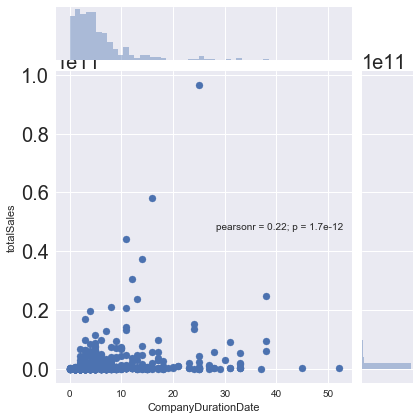

In [730]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['CompanyDurationDate'], y=df['totalSales'])
plt.show()

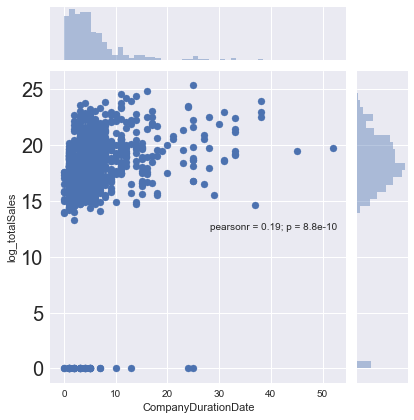

In [731]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['CompanyDurationDate'], y=df['log_totalSales'])
plt.show()

위의 두 그래프들 또한 상관관계가 각각 0.21, 0.19로 매출액 또한 회사 존속기간과 관계가 없다는 결론이 나온다.
1차 주제로 선정했던 것에 대한 결과는 결국, 신생기업이든 대기업이든 명성을 떠나서 '아이디어' 및 '게임 컨텐츠' 적인 면이 이쪽 분야에서는 좀더 고객들의 마음을 사로잡을 수 있는게 아닌가 싶다.

---------------------------------------------------------

다음으로는 동영상홍보기간대비 매출액과 다운로드에 관한 산점도들을 아래에서 볼 수 있다.

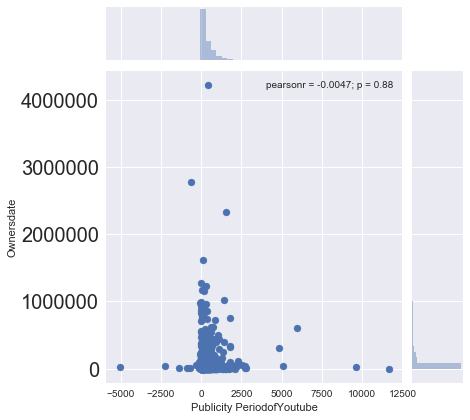

In [732]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['Publicity PeriodofYoutube'], y=df['Ownersdate'])
plt.show()

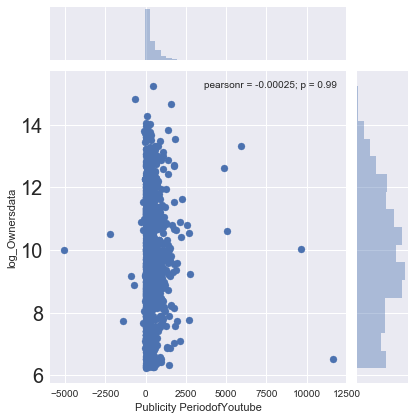

In [733]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['Publicity PeriodofYoutube'], y=df['log_Ownersdata'])
plt.show()

 x축들의 숫자들은 하루단위(day)이다. 현재 그래프를 보면 x가 음수 인 부분도 있는데 , 이는 게임을 출시이후 동영상을 등록하여 홍보했다는 의미이지만, 스팀에 게임을 출시할 경우 동영상을 같이 올리기 때문에,스팀에 올린날짜가 곧 동영상 홍보기간이 된다. 그렇기에  필자가 여러 사이트에서 특정 게임의 발매이전 홍보를 위한 동영상들을 찾지 못한 경우, 유튜브에 있는 게임 동영상들을 찾아 그것들의 등록된 날짜를 집어넣은 값들을 의미한다. 즉 x가 음수 인 부분들은 스팀발매일과 동일한 날짜로 치부 되기때문에 x가 0과 같다고 할 수있다.
결론적으로 말하면, p_value가 99이기때문에 사실상 믿을 수 없는 데이터이며, 동영상홍보기간 대비 매출액과 다운로드에 관해서는 어떠한 관련도 없다는 것을 알 수있다. 또한 양수 쪽에서 outlier인 부분들은 (동영상 홍보기간이 4~5000일을 넘는 값들) 대개 예전에 스팀이전에 출시됬던 추억의 게임들이 다시 스팀을 통해 재판매 될 때 나타나는 점들이다.  예전에 이미 발매된 게임들 중 정말 오래된게임들(1970~1999년도 생성된 게임들)은 발매된 당시 날짜를 통하여 홍보기간으로 채택하였기 때문에 저런 값이 나온다.

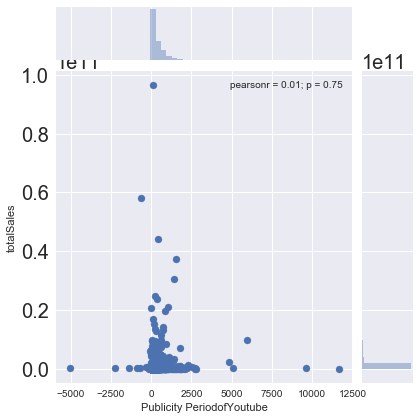

In [734]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['Publicity PeriodofYoutube'], y=df['totalSales'])
plt.show()

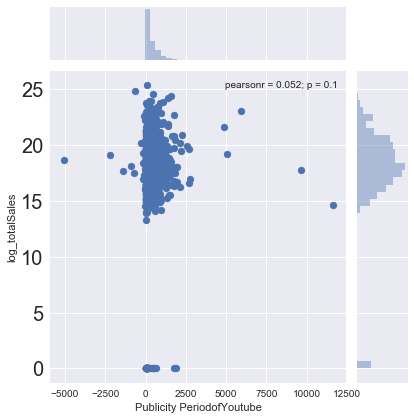

In [735]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df2['Publicity PeriodofYoutube'], y=df['log_totalSales'])
plt.show()

결론적으로 놓고보면, 홍보기간 과 회사의 존속연수는 게임판매나 다운로드에 영향을 주지 않고,  프로그래밍관련 공부를 한 후에 게임산업에 뛰어드는 누구라도, 아이디어를 갖고 있고 고객들의 마음에 드는 게임을 만들면, 누구에게나 공평하게 대박을 칠 기회를 준다는 결과를 알 수 있다. 

-------------------------------------------------------------------------

다음은 각 나라들을 기준으로 어떠한 패턴이 있는지 확인하기 위한 작업을 시작한다.
첫번째로 국적이 불분명한 자들은 값을 넣어주지 않아서, Nan 값으로 들어가 있는데, 이를 'Uncertain' 으로 값을 넣어준다.

In [736]:
df2.Nationaility=df2.Nationaility.fillna('Uncertain')

In [737]:
print("Count Country: ", len(np.unique(df2.Nationaility)))
(np.unique(df2.Nationaility))

Count Country:  59


array(['Argentina', 'Austrailia', 'Austria', 'Belarus', 'Belgium',
       'Brazil', 'Canada', 'China', 'Colombia', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Finland',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'India', 'Indonesia', 'Italy', 'Japan', 'Latvia', 'Lithuania',
       'Macedonia', 'Mexico', 'Moldova', 'Netherlands', 'NewZealand',
       'Norway', 'Pakistan', 'Phillippines', 'Poland', 'Portugal',
       'Republic of South Africa', 'Romania', 'Russia', 'Serbia',
       'Singapore', 'Slovakia', 'South Korea', 'Spain', 'Srilanka',
       'Sweden', 'Switzerland', 'Taiwan', 'Tanzania', 'Thailand', 'Turkey',
       'UK', 'USA', 'Ukraine', 'Uncertain', 'United Arab Emirates',
       'Venezuela', 'Vietnam'], dtype=object)

보다 시피 총 59개의 나라들이 나오고, 이중에서 불분명한 국적을 뜻하는 Uncertain을 빼면 , 도합 58개의 국적을 가진사람들이 steam 플랫폼을 이용하는 것을 볼 수 있다. 이를 대륙별로 구분지을 것이며, 대륙구분은 위키백과를 참조하였다.

In [738]:
Continent=defaultdict(list)
Continent['America']=['Argentina','Mexico','Brazil','Colombia','Venezuela','USA','Canada','Dominican Republic']
Continent['Africa']=['Republic of South Africa','Tanzania']
Continent['Asia&Oceania']=['South Korea','China','Japan','Taiwan',
                           'Vietnam','Indonesia','Phillippines','Singapore','Thailand',
                          'Austrailia','NewZealand',
                           'India','Pakistan','Srilanka']

Continent['Middle East']=['Cyprus','United Arab Emirates']
Continent['Europe']=['Russia','Austria','Belarus','Georgia','Hungary','Moldova','Poland','Ukraine','Czech Republic','Slovakia',
                    'UK','Belgium','France','Germany','Netherlands','Switzerland',
                    'Croatia','Greece','Italy','Macedonia','Portugal','Serbia','Romania','Spain','Turkey',
                    'Denmark','Finland','Iceland','Latvia','Lithuania','Norway','Sweden' ]

아래는 스팀을 이용하는 대륙별 현황이다.

In [739]:
count_continent=pd.DataFrame({'ContinentName':list(Continent.keys()),
              'Count_each_Continent':[
                  (len(Continent['America'])),
                    (len(Continent['Africa'])),
                   (len(Continent['Asia&Oceania'])),
                    (len(Continent['Middle East'])),
                   (len(Continent['Europe']))
                                     ]})

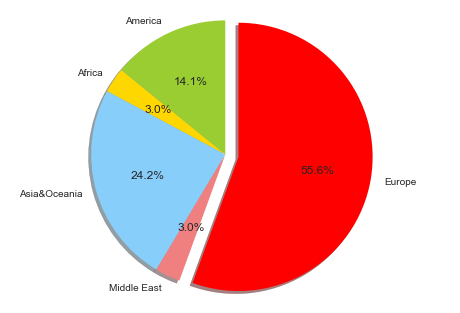

In [740]:
labels=count_continent.ContinentName
#순서 America,Africa,Asia&Oceania,Middle East, Europe
sizes=[14,3,24,3,55]
colors=['yellowgreen','gold','lightskyblue','lightcoral','red']
explode=(0,0,0,0,0.1)
plt.pie(sizes,explode=explode,labels=labels,colors=colors,
      autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

위키백과를 참조함과 동시에 월드컵 시드배정구분도 적용하여서, 아시아와 오세아니아들을 합쳤고, 러시아는 유럽으로 들어가게하였다. 
이 파이차트는 전체 58개 국가들을 대륙별로 나누어서, 스팀을 이용하는 대륙들의 점유율을 보여준다.
이를 보면서 유럽이 거의 반이상을 차지하고 있기 때문에, 필자는 유럽을 동서남북 유럽으로 또 나누어서 원차트를 그려보았다.

In [741]:
Seperate_Europe_Continent=defaultdict(list)
Seperate_Europe_Continent['East Europe']=['Russia','Austria','Belarus','Georgia','Hungary','Moldova','Poland','Ukraine','Czech Republic','Slovakia']
Seperate_Europe_Continent['North Europe']=['Denmark','Finland','Iceland','Latvia','Lithuania','Norway','Sweden']
Seperate_Europe_Continent['South Europe']=['Croatia','Greece','Italy','Macedonia','Portugal','Serbia','Romania','Spain','Turkey']
Seperate_Europe_Continent['West Europe']=['UK','Belgium','France','Germany','Netherlands','Switzerland']

In [742]:
Seperate_Europe_continent_df=pd.DataFrame({'EWSN':list(Seperate_Europe_Continent.keys()),
              'Count_each_Continent':[
                  (len(Seperate_Europe_Continent['East Europe'])),
                    (len(Seperate_Europe_Continent['North Europe'])),
                   (len(Seperate_Europe_Continent['South Europe'])),
                    (len(Seperate_Europe_Continent['West Europe']))
                                     ]})

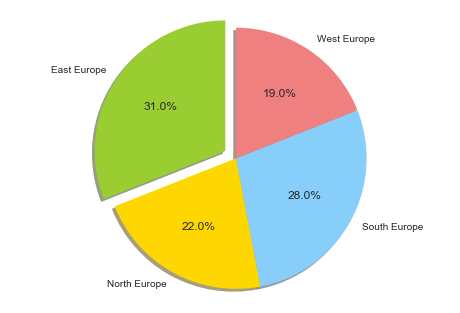

In [743]:
labels=Seperate_Europe_continent_df.EWSN
sizes=[31,22,28,19]
colors=['yellowgreen','gold','lightskyblue','lightcoral']
explode=(0.1,0,0,0)
plt.pie(sizes,labels=labels,colors=colors,explode=explode,
      autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()

유럽중에서도 동유럽이 가장 스팀 발매 점유율이 높았으며, 그 뒤를 이어 남유럽, 북유럽, 서유럽으로 분포가 나뉘어진다.
하지만 이는 단순히 대륙별 점유율을 보여주는 것이기에, 좀더 자세하게 특정 나라들의 스팀점유율을 알아보고자한다.

In [744]:
df2['freq']=df2.groupby(df2.CompanyName)['Nationaility'].transform('count') #회사이름을 기준으로, 국적들을 확인하여 갯수를 센다.
#즉 중복된 회사들 갯수확인

In [745]:
df3=df2.drop_duplicates(subset='CompanyName', keep="last") #중복되는 회사이름들 삭제 

In [746]:
Country_Count=df3.Nationaility.value_counts().drop('Uncertain')
Country_Count

USA                         193
UK                           87
Russia                       44
Germany                      43
Canada                       43
Poland                       35
France                       32
Spain                        28
Sweden                       22
Austrailia                   18
Japan                        18
Finland                      18
Netherlands                  17
Ukraine                      17
China                        15
Czech Republic               13
Italy                        12
Brazil                       11
Denmark                       9
Turkey                        8
Serbia                        7
Hungary                       6
Portugal                      6
Austria                       6
Romania                       5
NewZealand                    4
India                         4
South Korea                   4
Norway                        4
Croatia                       4
Taiwan                        3
Argentin

위의 나온 결과들을 도표로 나타낸다.

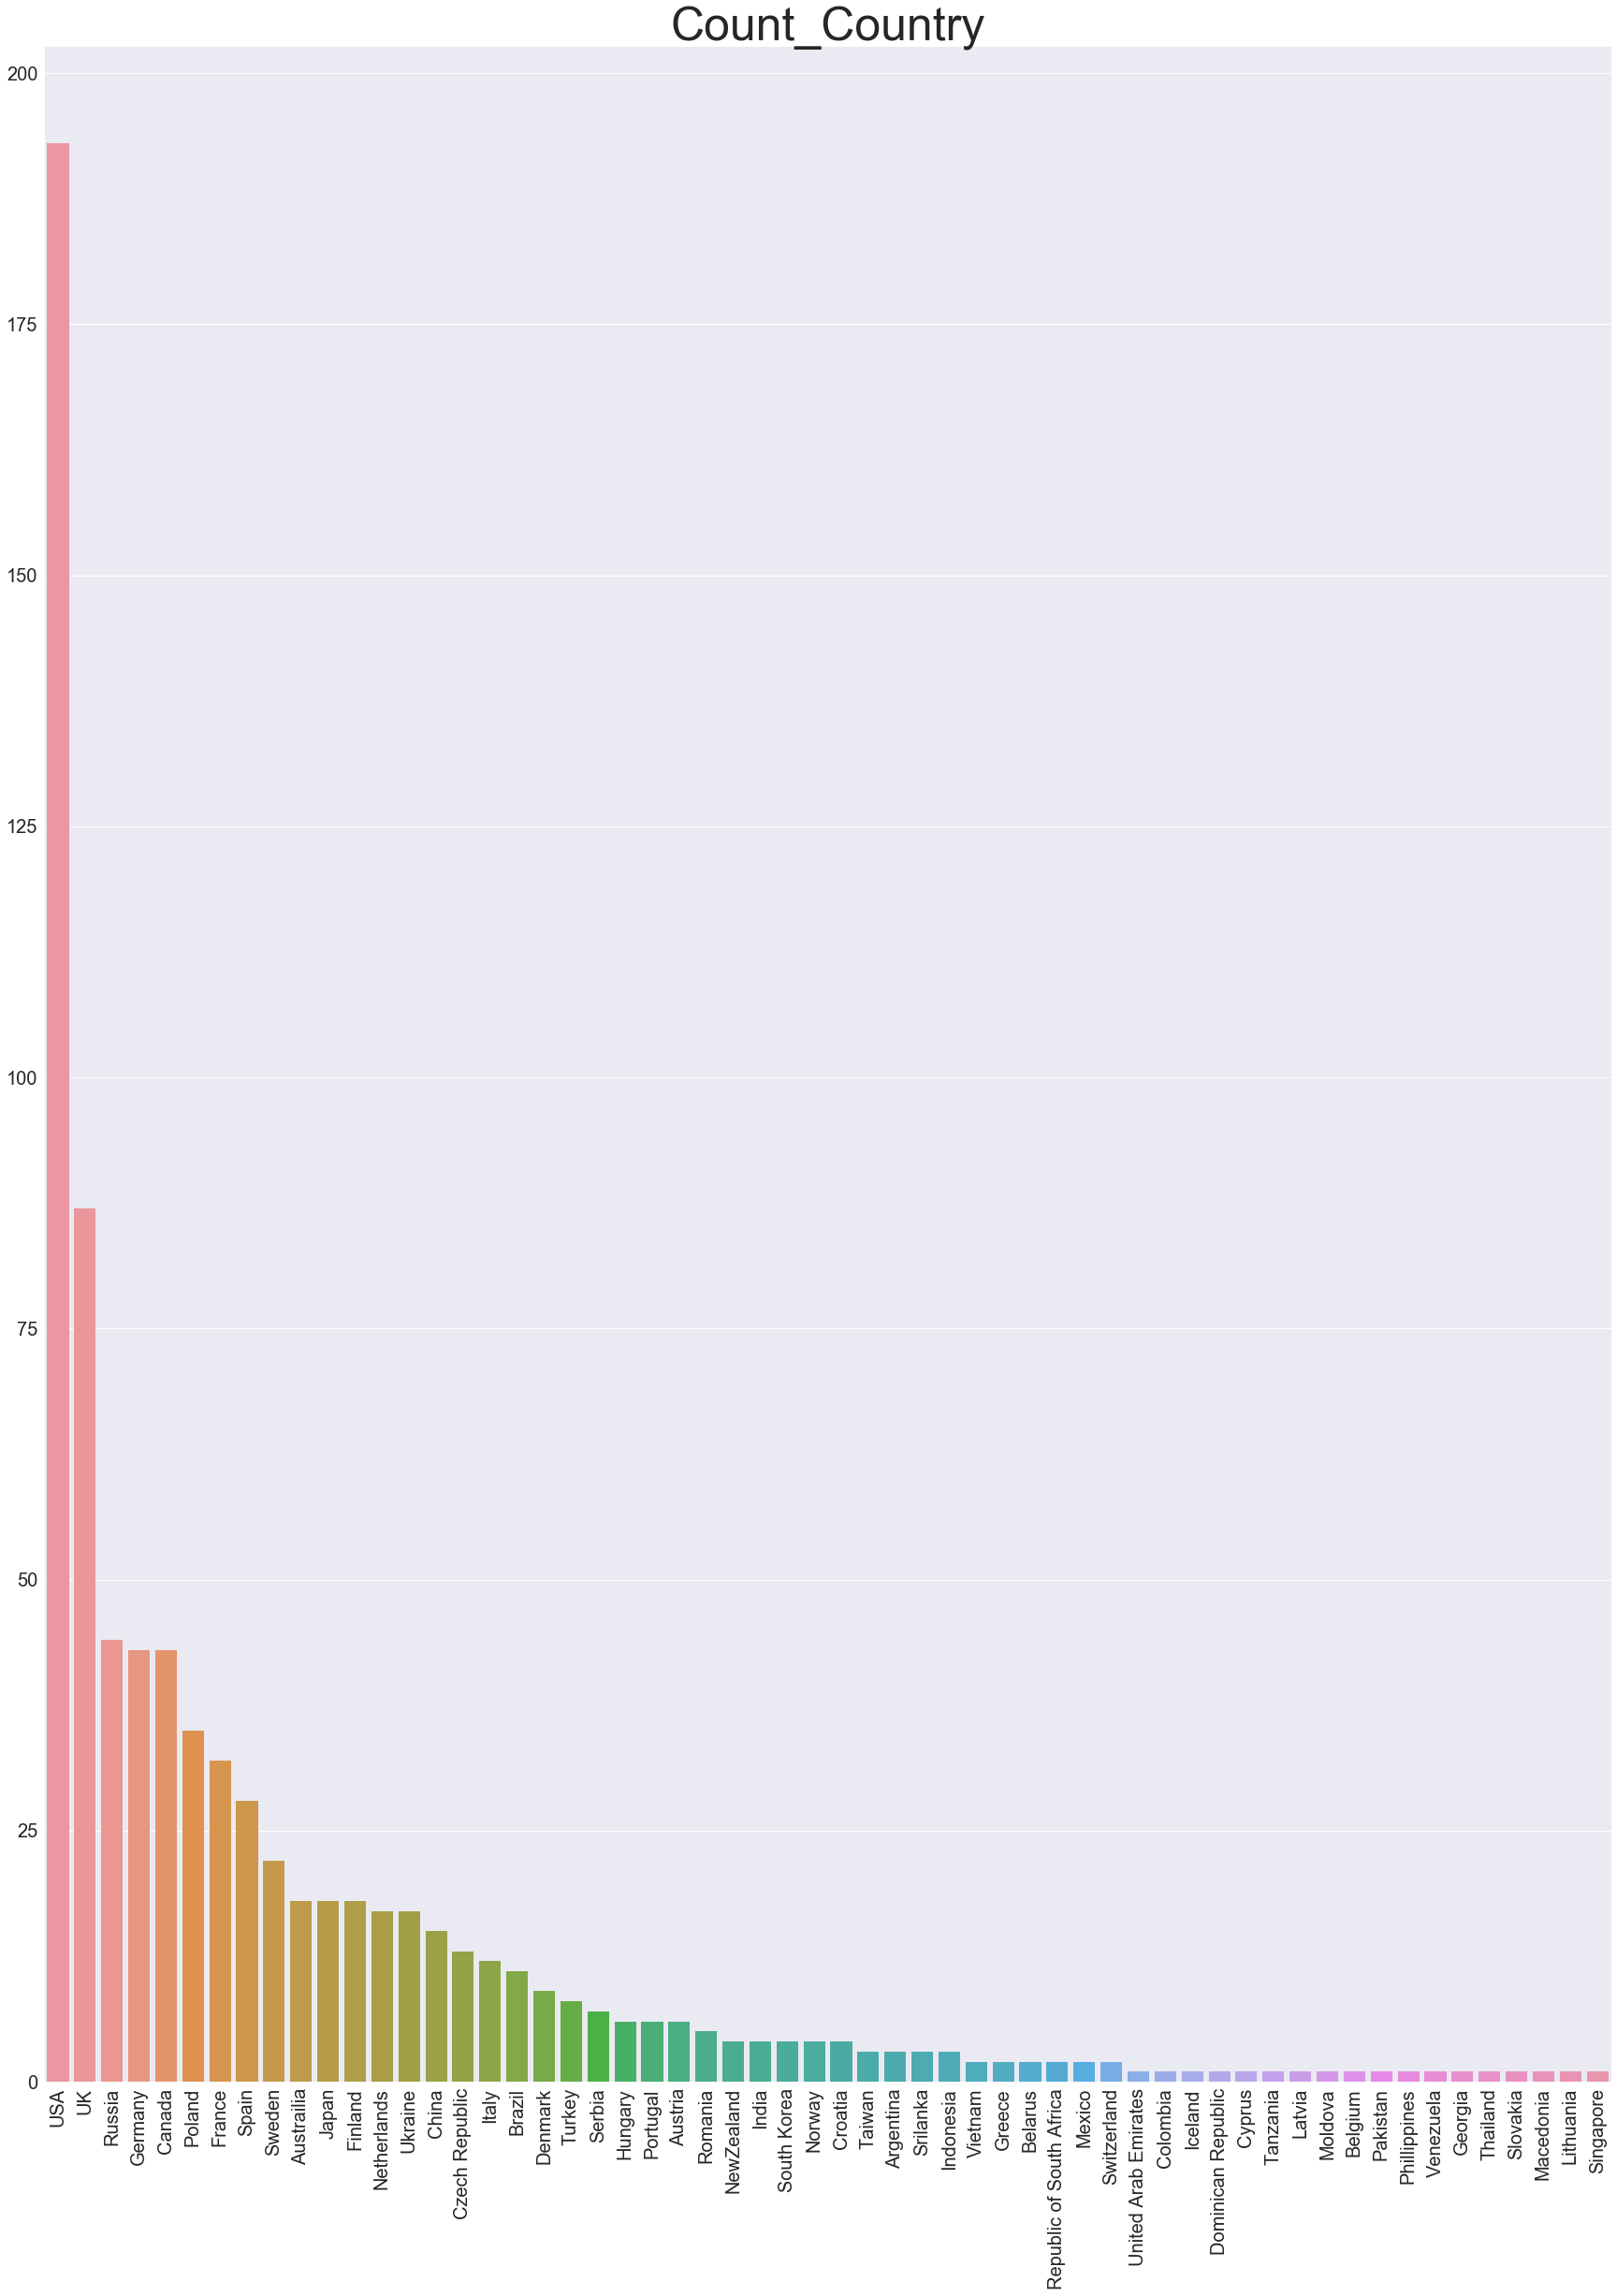

In [747]:
plt.figure(figsize=(30,40))
#df2.FoundingDateofCompany.value_counts().sort_index().valuex
ax=sns.barplot(Country_Count.index,Country_Count.values)
ax.set_xticklabels(Country_Count.index,rotation=90,fontsize=20)
ax.set_title('Count_Country',size=50)
plt.rc('ytick',labelsize=20)
plt.show()

미국은 사실 많은 게임개발자들, IT의 성지인 실리콘밸리를 생각하면 그렇게 놀랍지 않은 숫자이다.
하지만 필자가 제일 놀란 부분은 러시아와 폴란드이다.
러시아와 폴란드가 각각 3위, 6위에 놓여있는데, 이는 왜 그런지에 대한 사회적 접근(각 나라별 산업비중의 우선순위 혹은 각 나라별 ICT분야의 성장속도)을 필요로 요할 것 같고, 추후 새로 분석할 여지가 남아있다. 

In [748]:
#인디개발자+3년이상회사및개발자들포함
temp_Finland=df2[df2.loc[:,'Nationaility']=='Finland' ]
temp_Poland=df2[df2.loc[:,'Nationaility']=='Poland']
temp_Russia=df2[df2.loc[:,'Nationaility']=='Russia']

temp_UK=df2[df2.loc[:,'Nationaility']=='UK']
temp_Germany=df2[df2.loc[:,'Nationaility']=='Germany']
temp_Canada=df2[df2.loc[:,'Nationaility']=='Canada']

temp_France=df2[df2.loc[:,'Nationaility']=='France']
temp_Spain=df2[df2.loc[:,'Nationaility']=='Spain']
temp_Japan=df2[df2.loc[:,'Nationaility']=='Japan']
temp_Sweden=df2[df2.loc[:,'Nationaility']=='Sweden']

In [749]:
df2.loc[(df2.Nationaility=='Finland') & df2.CheckStartUporNewbyDeveloper==1]

,gameName,InvestigateDate,ReleaseDateinSteam,Rating,Price,EngineorLanguage,VideoRegisterDate,CompanyName,FoundingDateofCompany,Nationaility,...,TotalSteamReview,Publicity PeriodofYoutube,CompanyDurationDate,totalSales,ReleaseDate_Year,CheckStartUporNewbyDeveloper,CountallCompanybyCountry,log_totalSales,log_Ownersdata,freq
39,Grab the Bottle,2017-07-26,2017-05-23,NaN,7500,Unity,2016-08-26,Kamina Dimension,2016,Finland,...,22,270,1,50250000,2017,1,1,17.732521,8.809863,1
314,Puzzle Nebula,2017-06-22,2016-02-09,NaN,3300,Unity,2014-12-08,Multiverse Games,2014,Finland,...,5,428,3,18192900,2016,1,1,16.716542,8.614864,1
497,INFRA,2017-07-07,2016-01-16,9.0,27000,Sourse Engine,2013-02-15,Loiste Interactive,2013,Finland,...,398,1065,4,446526000,2016,1,1,19.917008,9.713416,1
520,Lowglow,2017-07-08,2015-12-03,8.0,8500,cocos2d,2015-07-28,Rockodile,2014,Finland,...,378,128,3,894361500,2015,1,1,20.611621,11.563799,1
535,Kumoon : Ballistic Physics Puzzle,2017-07-09,2015-11-10,6.0,3300,ShiVa3D,2015-05-30,Lucky You Studio,2014,Finland,...,69,164,3,27683700,2015,1,1,17.136354,9.034677,1
642,Bomb Defense,2017-07-13,2017-07-05,NaN,5500,Unity,2017-02-02,Mitorah Games,2016,Finland,...,2,153,1,3690500,2017,1,1,15.121273,6.508769,1
698,BADLAND: Game of the Year Edition,2017-07-15,2015-05-27,9.0,10500,cocos2d,2013-04-04,Frogmind,2012,Finland,...,858,783,5,1278448500,2015,1,1,20.968913,11.709783,1
717,Sandmason,2017-07-16,2015-05-04,8.0,4400,Microsoft's XNA framework,2013-11-28,GoodVole,2013,Finland,...,53,522,4,60112800,2015,1,1,17.911733,9.522374,1
723,Parcel,2017-07-16,2015-04-23,9.0,5500,Unity,2014-06-26,Polar Bunny Ltd,2013,Finland,...,102,301,4,83011500,2015,1,1,18.234490,9.621986,1
729,Lakeview Cabin Collection,2017-07-16,2015-03-25,9.0,10500,StillQuestioning,2013-08-15,Roope Tamminen,2014,Finland,...,674,587,3,433345500,2015,1,1,19.887046,10.627915,1


In [750]:
#3년이하 인디개발자 및 신생기업만포함
temp2_Finland=df2.loc[(df2.Nationaility=='Finland') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Poland=df2.loc[(df2.Nationaility=='Poland') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Russia=df2.loc[(df2.Nationaility=='Russia') & df2.CheckStartUporNewbyDeveloper==1]
temp2_USA=df2.loc[(df2.Nationaility=='USA') & df2.CheckStartUporNewbyDeveloper==1]
temp2_UK=df2.loc[(df2.Nationaility=='UK') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Germany=df2.loc[(df2.Nationaility=='Germany') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Canada=df2.loc[(df2.Nationaility=='Canada') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Austrailia=df2.loc[(df2.Nationaility=='Austrailia') & df2.CheckStartUporNewbyDeveloper==1]
temp2_France=df2.loc[(df2.Nationaility=='France') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Spain=df2.loc[(df2.Nationaility=='Spain') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Japan=df2.loc[(df2.Nationaility=='Japan') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Sweden=df2.loc[(df2.Nationaility=='Sweden') & df2.CheckStartUporNewbyDeveloper==1]
temp2_Netherlands=df2.loc[(df2.Nationaility=='Netherlands') & df2.CheckStartUporNewbyDeveloper==1]
temp2_China=df2.loc[(df2.Nationaility=='China') & df2.CheckStartUporNewbyDeveloper==1]

In [751]:
Finland_rv = sp.stats.norm(temp_Finland.log_Ownersdata.mean(), temp_Finland.log_Ownersdata.std())
Russia_rv = sp.stats.norm(temp_Russia.log_Ownersdata.mean(), temp_Russia.log_Ownersdata.std())
Poland_rv=sp.stats.norm(temp_Poland.log_Ownersdata.mean(), temp_Poland.log_Ownersdata.std())
#mu = 0
#std = 1

#rv

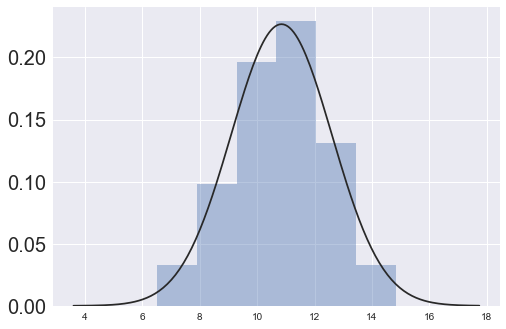

In [752]:
sns.distplot(sorted(temp_Finland.log_Ownersdata), kde=False, fit=sp.stats.norm)
plt.show()

In [753]:
#plt.plot(sorted(temp_Russia.log_Ownersdata), rv.pdf(sorted(temp_Russia.log_Ownersdata)))
#plt.show()

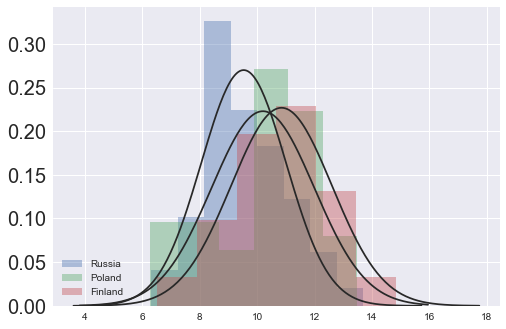

In [754]:
sns.distplot(sorted(temp_Russia.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Russia')
sns.distplot(sorted(temp_Poland.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Poland')
sns.distplot(sorted(temp_Finland.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Finland')
plt.legend(loc=3)

plt.show()

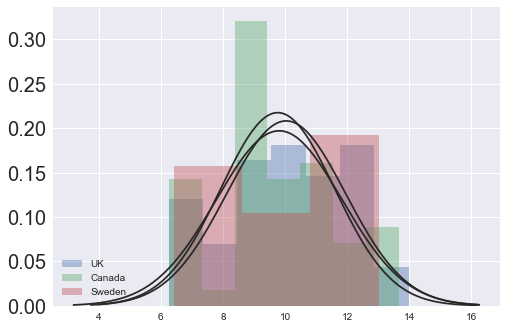

In [755]:
sns.distplot(sorted(temp_UK.log_Ownersdata), kde=False, fit=sp.stats.norm,label='UK')
sns.distplot(sorted(temp_Canada.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Canada')
sns.distplot(sorted(temp_Sweden.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Sweden')
plt.legend(loc=3)
plt.show()

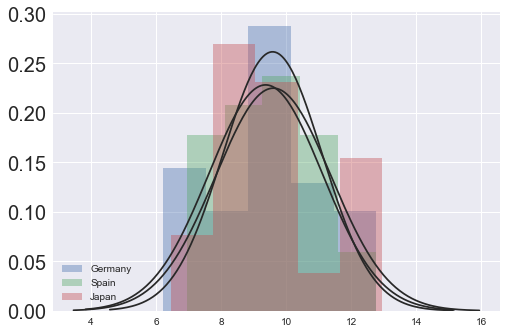

In [756]:
sns.distplot(sorted(temp_Germany.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Germany')
sns.distplot(sorted(temp_Spain.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Spain')
sns.distplot(sorted(temp_Japan.log_Ownersdata), kde=False, fit=sp.stats.norm,label='Japan')
plt.legend(loc=3)
plt.show()

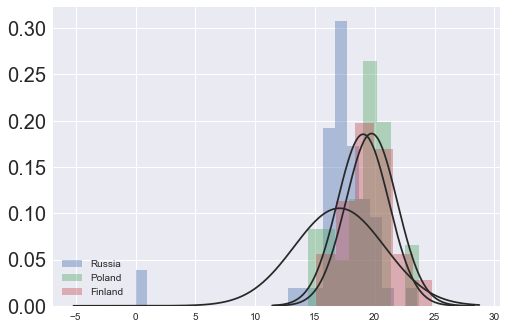

In [757]:
sns.distplot(sorted(temp_Russia.log_totalSales), kde=False, fit=sp.stats.norm,label='Russia')
sns.distplot(sorted(temp_Poland.log_totalSales), kde=False, fit=sp.stats.norm,label='Poland')
sns.distplot(sorted(temp_Finland.log_totalSales), kde=False, fit=sp.stats.norm,label='Finland')
plt.legend(loc=3)

plt.show()

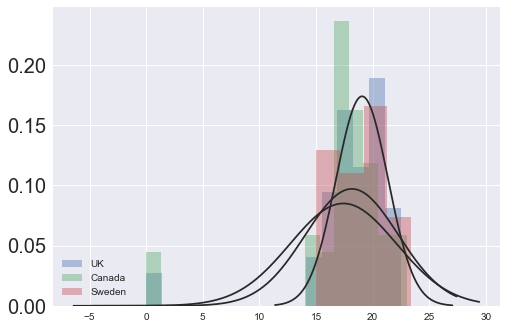

In [758]:
sns.distplot(sorted(temp_UK.log_totalSales), kde=False, fit=sp.stats.norm,label='UK')
sns.distplot(sorted(temp_Canada.log_totalSales), kde=False, fit=sp.stats.norm,label='Canada')
sns.distplot(sorted(temp_Sweden.log_totalSales), kde=False, fit=sp.stats.norm,label='Sweden')
plt.legend(loc=3)
plt.show()

이산 정규분포표를 이용하여 보니 핀란드,스웨덴(북유럽)의 매출액 평균이 타 국가에 비해 매출액이 높은편으로 나왔다.
이를 보고 필자는 연 평균 국가 노동시간이 낮은 나라 일수록 그 나라의 회사나 개발자들이 많은 게임을 스팀에 발매하고, 매출액이 높을 것 이라는 생각을 하였다. 그 이유로는 본업이 끝나고 난 후 여가시간이 많아, 자신의 취미생활에 오랜 시간을 쏟을 수 있기에 재미삼아 게임을 만들어서 스팀에 올려 팔 수 있다고 생각하기 때문이다.
한국같은 경우, 필자의 생각으로는 아직까지 강도높은 업무 및 일상생활 때문에 자신의 여가시간이 부족하여 자신만의 게임을 만들 시간이 없는 사람들이 많다고 생각하여, 이러한 스팀 플랫폼을 이용한 게임출시가 저조한 것이 아닐까 생각된다.
이러한 이유로 필자는 2016년 기준 OECD 국가 연평균 노동시간을 기준으로 하여 게임 매출액과 보유자수에 상관관계가 있는지 확인하는 작업을하였다.


Count_country 도표를 기준, 15위까지 나타난 국가들을 대상으로 (한 국가당 15개 이상의 회사수+인디개발자 수 ) 진행하였는데, 우크라이나는 국가 노동시간을 나타내는 통계가 나타나지않아서 제외하여, 실질적으로 14개 국가가 대상이되었다. 
15위까지 Ukraine,China를 제외하고는 모두 OECD 가입국들임을 알 수 있다.

In [760]:
#2016년 기준 OECD 국가 노동시간 (year_labour_hour)
#벨기에와스위스는 2015년도 수치로 갑니다.(Belgium & Switerland had no 2016 labour data, so assigned 2015 data)
#중국은 2014년 수치 2200(China had no 2015 2014 labour data, so assigned 2014 data) 


df2.loc[df.Nationaility=='South Korea','OECDURL_Labour_hours']=2069
df2.loc[df.Nationaility=='Austrailia','OECDURL_Labour_hours']=1669
df2.loc[df.Nationaility=='Canada','OECDURL_Labour_hours']=1703
df2.loc[df.Nationaility=='Czech Republic','OECDURL_Labour_hours']=1770
df2.loc[df.Nationaility=='Denmark','OECDURL_Labour_hours']=1410
df2.loc[df.Nationaility=='Finland','OECDURL_Labour_hours']=1653
df2.loc[df.Nationaility=='France','OECDURL_Labour_hours']=1472
df2.loc[df.Nationaility=='Germany','OECDURL_Labour_hours']=1363
df2.loc[df.Nationaility=='Greece','OECDURL_Labour_hours']=2035
df2.loc[df.Nationaility=='Hungary','OECDURL_Labour_hours']=1761
df2.loc[df.Nationaility=='China','OECDURL_Labour_hours']=2200

df2.loc[df.Nationaility=='Iceland','OECDURL_Labour_hours']=1879
df2.loc[df.Nationaility=='Italy,','OECDURL_Labour_hours']=1730
df2.loc[df.Nationaility=='Japan','OECDURL_Labour_hours']=1713
df2.loc[df.Nationaility=='Mexico','OECDURL_Labour_hours']=2255
df2.loc[df.Nationaility=='Netherlands','OECDURL_Labour_hours']=1430
df2.loc[df.Nationaility=='NewZealand','OECDURL_Labour_hours']=1752
df2.loc[df.Nationaility=='Norway','OECDURL_Labour_hours']=1424
df2.loc[df.Nationaility=='Poland','OECDURL_Labour_hours']=1928
df2.loc[df.Nationaility=='Portugal','OECDURL_Labour_hours']=1842
df2.loc[df.Nationaility=='Spain','OECDURL_Labour_hours']=1695

df2.loc[df.Nationaility=='Sweden','OECDURL_Labour_hours']=1621
df2.loc[df.Nationaility=='UK','OECDURL_Labour_hours']=1676
df2.loc[df.Nationaility=='Russia','OECDURL_Labour_hours']=1974
df2.loc[df.Nationaility=='USA','OECDURL_Labour_hours']=1783
df2.loc[df.Nationaility=='Austria','OECDURL_Labour_hours']=1601
df2.loc[df.Nationaility=='Swizterland','OECDURL_Labour_hours']=1590
df2.loc[df.Nationaility=='Belgium','OECDURL_Labour_hours']=1551
OECD_average_Labour_2016=1763 #2016 oecd 평균 근무시간

In [761]:
df2['EachCountry_mu_of_logownersdata']=df2.groupby(df2.Nationaility)['log_Ownersdata'].transform('mean') #각 나라들의 log_보유자수 평균
df2['EachCountry_mu_of_logt_totalsales']=df2.groupby(df2.Nationaility)['log_totalSales'].transform('mean') # 각 나라들의 log_매출액 평균
#df2[df2.Nationaility=='Finland']
#df2.groupby([df2.Nationaility,df2.EachCountry_mu_of_logownersdata]).all()
OECD_country=['South Korea','Austrailia','Canada','Czech Republic','Denmark','Finland','France','Germany','Greece','Hungary'
              ,'Iceland','Italy','Japan','Mexico','Netherlands','NewZealand','Norway','Poland','Portugal','Spain','Sweden'
              ,'UK','Russia','USA','Austria','Swizterland','Belgium'  
             
             ]

In [779]:
print(temp2_Finland.log_totalSales.mean())
print(temp2_France.log_totalSales.mean())
print(temp2_China.log_totalSales.mean())
print(temp2_Japan.log_totalSales.mean())
print(temp2_Netherlands.log_totalSales.mean())
print(temp2_Poland.log_totalSales.mean())
print(temp2_Spain.log_totalSales.mean())
print(temp2_Sweden.log_totalSales.mean())
print(temp2_Austrailia.log_totalSales.mean())


19.167755420405424
19.42559617006844
15.780878608551312
17.73745614388726
16.0377066887632
18.691784004024836
16.917830738730892
18.89945433981254
17.079895524148796


In [780]:

#USA 18.251059   , 9.895952
#UK   18.161374   , 10.035179
#Russia 17.044488 , 9.530699
#Germany 18.053787 , 9.371847
#Canada  17.408954 , 9.762439
#Poland  19.030781 , 10.201964
#France  19.218783 , 9.997705
#SWedem  19.063185 , 9.809803
#Spain  17.246786 , 9.586187
#Austrailia 16.515326 , 9.995599
#japan    18.811459 , 9.608954
#Finland 19.733124 , 10.849448
#Netherlands    17.396725 ,9.722219
#Ukraine   15.882004 ,
#China   15.097124, 9.057949
#df2.groupby('OECDURL_Labour_hours')['Nationaility'].all()
list_of_log_totalsales=[18.251059
                       ,18.161374,
                         17.044488,
                         18.053787,
                      17.408954,
                        19.030781,
                         19.218783,
                      19.063185,
                        17.246786,
                        16.515326,
                         18.811459,
                   19.733124,
                        17.396725,
                         15.097124                 
                       ]
list_of_OnlyStartUp_log_totalsales=[17.8957936581532,17.448431437922867,17.522482135625403,17.289067140358462,16.60955718191626,
                                   18.691784004024836,19.42559617006844,18.89945433981254,16.917830738730892,17.079895524148796,
                                    17.73745614388726,19.167755420405424,16.0377066887632,15.780878608551312
                                   ]
list_of_log_Labour_hours=[1783,1676,1974,1363,1703,1928,1472,1621,1695,1669,1713,1653,1430,2200]
list_of_log_Ownersdata=[9.895952,10.035179,9.530699,9.371847,9.762439,10.201964,9.997705,
                       9.809803,9.586187,9.995599,9.608954,10.849448,9.722219,9.057949]
list_of_StartupRatio=[55.440415,64.367816,68.181818,55.813953,69.767442,51.428571,50.000000,45.454545,
                     53.571429,83.333333,33.333333,77.777778,47.058824,80.000000]

In [781]:
temp_df=pd.DataFrame({'Labour_hours':list_of_log_Labour_hours,
                      'log_totalsales':list_of_log_totalsales,
                      'log_Ownersdata':list_of_log_Ownersdata,
                      'StartupRatio':list_of_StartupRatio,
                      'OnlyStartup_log_totalsales':list_of_OnlyStartUp_log_totalsales
                      },index = ['USA','UK','Russia','Germany','Canada','Poland','France',
                                'Sweden','Spain','Astrailia','Japan','Finland','Netherlands',
                                 'China'
                                ])

In [785]:
temp_df

,Labour_hours,OnlyStartup_log_totalsales,StartupRatio,log_Ownersdata,log_totalsales
USA,1783,17.895794,55.440415,9.895952,18.251059
UK,1676,17.448431,64.367816,10.035179,18.161374
Russia,1974,17.522482,68.181818,9.530699,17.044488
Germany,1363,17.289067,55.813953,9.371847,18.053787
Canada,1703,16.609557,69.767442,9.762439,17.408954
Poland,1928,18.691784,51.428571,10.201964,19.030781
France,1472,19.425596,50.000000,9.997705,19.218783
Sweden,1621,18.899454,45.454545,9.809803,19.063185
Spain,1695,16.917831,53.571429,9.586187,17.246786
Astrailia,1669,17.079896,83.333333,9.995599,16.515326


In [786]:
agg_func={
    'CheckStartUporNewbyDeveloper':'sum',
    'CountallCompanybyCountry':'sum'
}
temp_test=df3.groupby(['Nationaility']).agg(agg_func)
temp_test=temp_test.reset_index()


temp_test['RatioofStartUp']=(temp_test.CheckStartUporNewbyDeveloper/temp_test.CountallCompanybyCountry)*100

probabilityofStartup=temp_test.loc[temp_test.CountallCompanybyCountry>=15]

probabilityofStartup=probabilityofStartup.drop(probabilityofStartup.index[14:16])

probabilityofStartup


,Nationaility,CheckStartUporNewbyDeveloper,CountallCompanybyCountry,RatioofStartUp
1,Austrailia,15,18,83.333333
6,Canada,30,43,69.767442
7,China,12,15,80.000000
14,Finland,14,18,77.777778
15,France,16,32,50.000000
17,Germany,24,43,55.813953
24,Japan,6,18,33.333333
30,Netherlands,8,17,47.058824
35,Poland,18,35,51.428571
39,Russia,30,44,68.181818


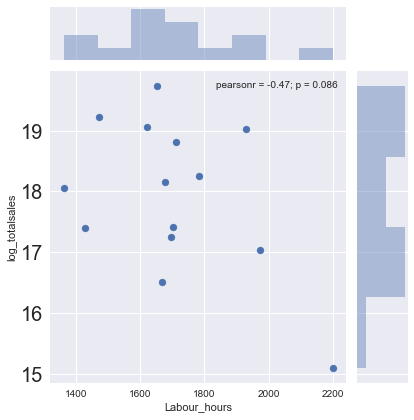

In [765]:
plt.figure(figsize=(10,10))
sns.jointplot(x=temp_df['Labour_hours'], y=temp_df['log_totalsales'])
plt.show()

위  그래프를 보면 상관관계가 -0.47임을 알 수 있고, OECD 노동시간이 낮을수록 매출액이 높은 게임을 만든다라고 생각 할 수있다. 하지만 아웃라이어(중국)때문에 표가 이렇게 그려진 것이기에 중국을 제외하고 표를 다시 보겠다.

In [766]:
tt=temp_df.drop(temp_df.index[13])
tt

,Labour_hours,StartupRatio,log_Ownersdata,log_totalsales
USA,1783,55.440415,9.895952,18.251059
UK,1676,64.367816,10.035179,18.161374
Russia,1974,68.181818,9.530699,17.044488
Germany,1363,55.813953,9.371847,18.053787
Canada,1703,69.767442,9.762439,17.408954
Poland,1928,51.428571,10.201964,19.030781
France,1472,50.000000,9.997705,19.218783
Sweden,1621,45.454545,9.809803,19.063185
Spain,1695,53.571429,9.586187,17.246786
Astrailia,1669,83.333333,9.995599,16.515326


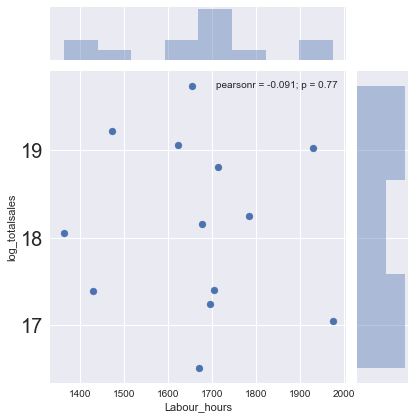

In [767]:
plt.figure(figsize=(10,10))
sns.jointplot(x=tt['Labour_hours'], y=tt['log_totalsales'])
plt.show()

위와같이 중국을 제거 하고 보면  OECD 노동시간이 낮을수록 매출액이 높은 게임을 만든다라는 말은 맞을 가능성이 거의 없다라는 결론이 나온다.
하지만 필자는, 좀 더 많은 데이터가 모인다면 확실하게 연관성을 찾고, 관계를 알 수 있지 않을 까 라는 너무나도 큰 아쉬움이 남는다. 
1000개의 데이터, 정확하겐 987개의 데이터는 상관관계를 알기에는 너무나 부족한 수이다.

아래는 노동시간대비 보유자 수 그래프이고 상관관계는 전혀 없다.

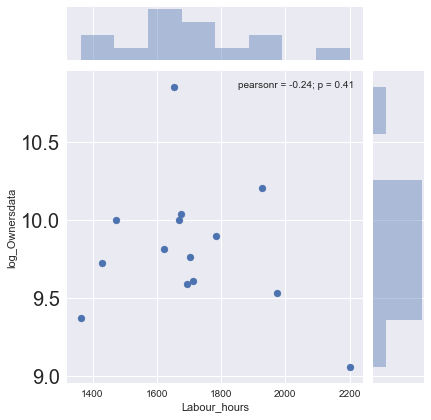

In [768]:
plt.figure(figsize=(10,10))
sns.jointplot(x=temp_df['Labour_hours'], y=temp_df['log_Ownersdata'])
plt.show()

마지막으로 아래 그래프는 노동시간 대비 국가별 스타트업 회사갯수 그래프다.

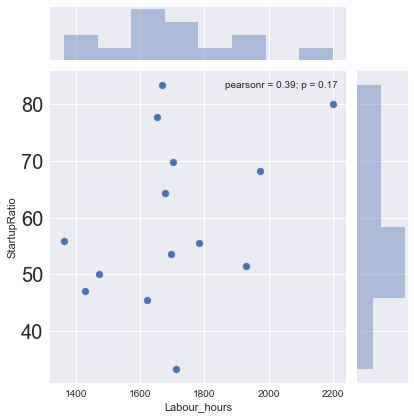

In [769]:
plt.figure(figsize=(10,10))
sns.jointplot(x=temp_df['Labour_hours'], y=temp_df['StartupRatio'])
plt.show()

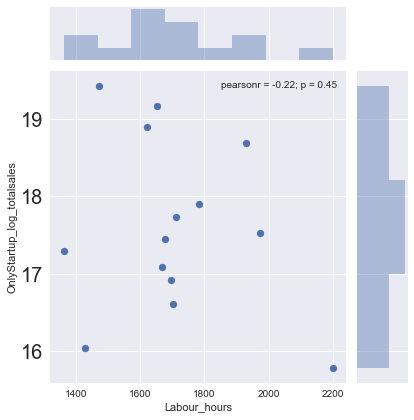

In [783]:

plt.figure(figsize=(10,10))
sns.jointplot(x=temp_df['Labour_hours'], y=temp_df['OnlyStartup_log_totalsales'])
plt.show()

혼자서 4개월 가량의 데이터수집과 데이터분석을 하면서 , 명확한 도메인지식없이 무작정 시작했던 데이터 수집이, 어느덧 데이터가 쌓이고 보니,보이지 않았던 것들도 볼 수 있었고 다양한 생각도 하게 되었다. 하지만 결론적으로는,  필자가 생각했던 것들은 상관관계가 뚜렷하게 나온 것들이 없다.

필자가 모은 데이터는 공개를 할 생각이지만, 아마 잘못된 정보들이 그래도 조금 있다고 생각된다.
이 부분에 대해서는 많은 분들이 피드백을 해주면 좋겠다고 생각한다.

In [788]:
df2.columns

Index(['gameName', 'InvestigateDate', 'ReleaseDateinSteam', 'Rating', 'Price',
       'EngineorLanguage', 'VideoRegisterDate', 'CompanyName',
       'FoundingDateofCompany', 'Nationaility', 'Ownersdate',
       'TotalSteamReview', 'Publicity PeriodofYoutube', 'CompanyDurationDate',
       'totalSales', 'ReleaseDate_Year', 'CheckStartUporNewbyDeveloper',
       'CountallCompanybyCountry', 'log_totalSales', 'log_Ownersdata', 'freq',
       'OECDURL_Labour_hours', 'EachCountry_mu_of_logownersdata',
       'EachCountry_mu_of_logt_totalsales'],
      dtype='object')